<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Shapley" data-toc-modified-id="Shapley-1">Shapley</a></span><ul class="toc-item"><li><span><a href="#Idea" data-toc-modified-id="Idea-1.1">Idea</a></span></li><li><span><a href="#Math" data-toc-modified-id="Math-1.2">Math</a></span></li><li><span><a href="#Pros" data-toc-modified-id="Pros-1.3">Pros</a></span></li><li><span><a href="#Cons" data-toc-modified-id="Cons-1.4">Cons</a></span></li></ul></li><li><span><a href="#Demo" data-toc-modified-id="Demo-2">Demo</a></span><ul class="toc-item"><li><span><a href="#Load-data-->-Train/Test-split-->-Train-model-->-Test-Prediction" data-toc-modified-id="Load-data-->-Train/Test-split-->-Train-model-->-Test-Prediction-2.1">Load data -&gt; Train/Test split -&gt; Train model -&gt; Test Prediction</a></span></li><li><span><a href="#Global-Interpretation" data-toc-modified-id="Global-Interpretation-2.2">Global Interpretation</a></span><ul class="toc-item"><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-2.2.1">Feature Importance</a></span></li><li><span><a href="#Summary-Plot" data-toc-modified-id="Summary-Plot-2.2.2">Summary Plot</a></span></li><li><span><a href="#PDP" data-toc-modified-id="PDP-2.2.3">PDP</a></span></li></ul></li><li><span><a href="#Local-Interpretation" data-toc-modified-id="Local-Interpretation-2.3">Local Interpretation</a></span><ul class="toc-item"><li><span><a href="#Force-Plot" data-toc-modified-id="Force-Plot-2.3.1">Force Plot</a></span></li><li><span><a href="#Cluster-Plot" data-toc-modified-id="Cluster-Plot-2.3.2">Cluster Plot</a></span></li></ul></li></ul></li></ul></div>

# Shapley

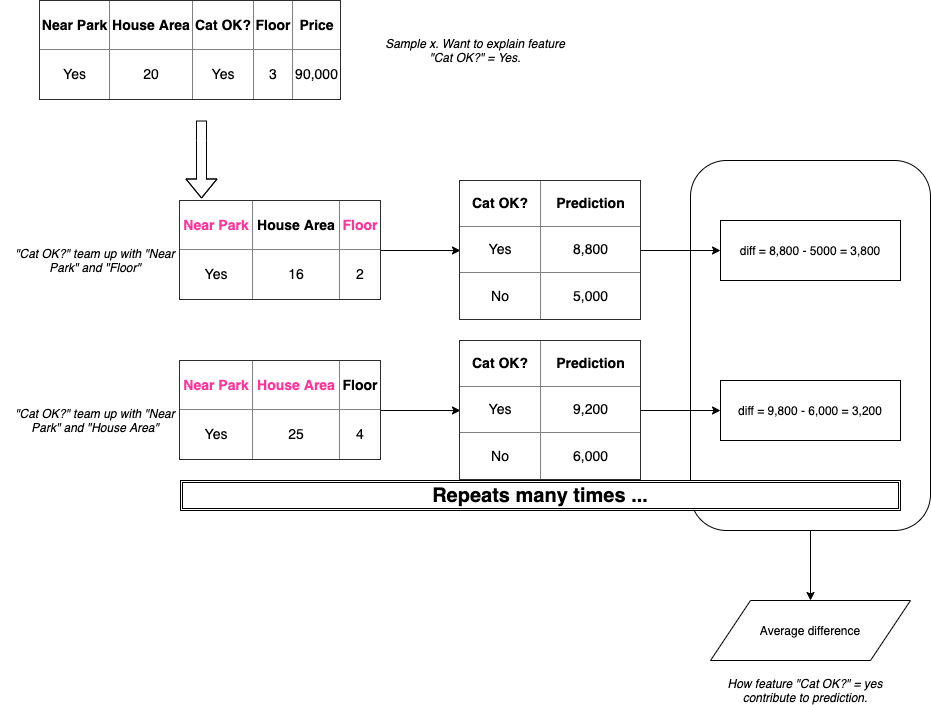

## Idea

For given sample $x$, a naive prediction is to use averate target $E$ as prediction. A model $\hat{f}$ will use $E + \delta$ as better prediction for sample $x$. That means, each feature of $x$ must contribute a part in $\delta$. Shapley value shows how contribution of feature value to prediction.

Shapley bases on Game Theory: There are 3 players A, B, C in the game. Game outcome when there are 3 players is $y$. When player C is missing, outcome is $y'$. That means player C contributes to the different in $y$ and $y'$.

For example: Dataset has 4 features: f1, f2, f3, f4. Pick sample $x$ that has f1=A, we want to know how f1=A affects prediction of $x$. Key idea is to quantify change in prediction when f1=A and f<>A.

1. Random pick a value for f1, for example: $f1=A$
2. Create a game in which f1 team up with f2, f4.
3. Generate a new sample: 
  - Pick a sample, then keep feature value for f2, f4.
  - Replace feature value of f3 by a random value of f3 in dataset.
  - Randomly pick a value for f1 in dataset: e.g. f1 = A.
  - We have sample: f1=A, f2, f3, f4.
4. Get prediction from blackbox model.
5. Randomly pick a new value for f1 in dataset: e.g. f1 = K. Then get black prediction.
6. Get average difference of prediction when f1=A and f1<>A.

Repeat step 2 to 6 many times by letting f1 team with different combination of other players. Final result is an estimation of how feature value f1=A affects prediction. 

## Math

In general, the Shaply value is approximated by:

$$
\hat{\phi}_{j}=\frac{1}{M}\sum_{m=1}^M\left(\hat{f}(x^{m}_{+j})-\hat{f}(x^{m}_{-j})\right)
$$

- $\hat{\phi}_{j}$: Contribution of feature $j$th on prediction $\hat{f}(x)$.
- Random sample a data point call $z$, then:
  - $\hat{f}(x^{m}_{+j})$: prediction for $x$ with some random features except $j$ replace by value from $z$. Loosedly speaking: new sample with $j$ untouched.
  - $\hat{f}(x^{m}_{-j})$: Similar to $\hat{f}(x^{m}_{+j})$, but $j$ feature is replaced by value from $z$. Loosedly speaking: new sample with $j$ changed.
- Repeat $M$ times then take average of difference.

For each value of feature $j$, model has to predict a new dataset generated around this particular value. For many values of feature $j$, the computation is exponential. This requires a lot of computation. This is a problem with Shapley.

## Pros

- Difference between prediction and average prediction is fairly distributed among feature values of instance. The feature contributions must add up to the difference of prediction for x and the average.
- Solid theory.
- Contrastive explanation: Compare prediction to average prediction.
- Improvement of Shapley is SHAP which has fast implementation, and includes global model interpretation. 

## Cons

- Explaination can be mis-interpreted. The interpretation of the Shapley value is: 

> Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.

This means: We cannot make statements about change in prediction for changes in input. 

- Calculate Shapley needs access to data.

- Like many other permutation-based interpretation methods, the Shapley value method suffers from inclusion of unrealistic data instances when features are correlated. 

# Demo

In [1]:
import xgboost as xgb
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from tabkit import opendata


shap.initjs()

## Load data -> Train/Test split -> Train model -> Test Prediction

In [2]:
Xtrain, Xtest, ytrain, ytest = opendata.ToyRegression().load()

In [3]:
Xtrain.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
182,0.09103,0.0,2.46,0.0,0.4880,7.155,92.2,2.7006,3.0,193.0,17.8,394.12,4.82
155,3.53501,0.0,19.58,1.0,0.8710,6.152,82.6,1.7455,5.0,403.0,14.7,88.01,15.02
280,0.03578,20.0,3.33,0.0,0.4429,7.820,64.5,4.6947,5.0,216.0,14.9,387.31,3.76
126,0.38735,0.0,25.65,0.0,0.5810,5.613,95.6,1.7572,2.0,188.0,19.1,359.29,27.26
329,0.06724,0.0,3.24,0.0,0.4600,6.333,17.2,5.2146,4.0,430.0,16.9,375.21,7.34


In [8]:
features = Xtrain.columns.tolist()
features

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

In [9]:
ytrain.mean(), ytrain.std()

(22.907915567282323, 9.429546081039085)

In [10]:
dtrain = xgb.DMatrix(Xtrain, ytrain)
dtest = xgb.DMatrix(Xtest, ytest)
# specify parameters via map
param = {'max_depth': 3, 'eta': 0.5, 'objective':'reg:squarederror'}
num_round = 100
bst = xgb.train(param, dtrain, num_round)
# make prediction
test_preds = bst.predict(dtest)

In [11]:
np.sqrt(metrics.mean_squared_error(ytest, test_preds))

3.2449154594947336

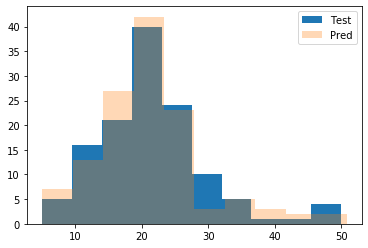

In [12]:
plt.hist(ytest, label='Test')
plt.hist(test_preds, alpha=0.3, label='Pred')
plt.legend()

## Global Interpretation

In [13]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(Xtrain)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Feature Importance

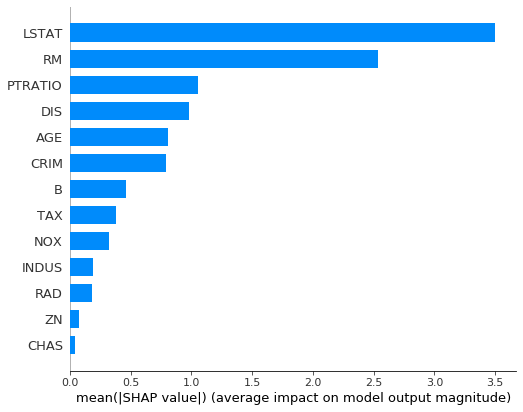

In [14]:
shap.summary_plot(shap_values, Xtrain, plot_type="bar")

In [15]:
# How to calculate this?
pd.DataFrame(np.sum(np.abs(shap_values), axis=0), index=Xtrain.columns, columns=['score']).sort_values(['score'], ascending=False)

,score
LSTAT,1326.546875
RM,962.015808
PTRATIO,400.478058
DIS,371.978027
AGE,306.551483
CRIM,300.438965
B,174.927612
TAX,145.071671
NOX,122.524048
INDUS,73.100349


> The feature importance plot is useful, but contains no information beyond the importances. 

### Summary Plot

Combine feature importance and feature effect. 

- Y axis: Features
- X axis: Shapley
- Color: Feature value from low to high.F

We can get a sense of feature distribution and their shapley value.

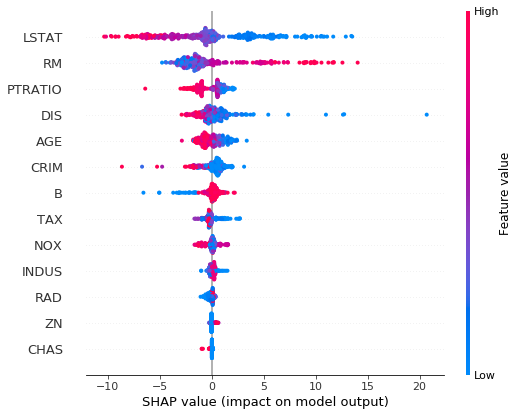

In [16]:
shap.summary_plot(shap_values, Xtrain)

### PDP

Even better than Summary plot. It shows more details relationship between feature values and shapley.

- X axis: Feature values
- Y axis: Shapley value
- Shapley variance on Y axis: same temperature value but has difference affect to prediction -> suggest an interaction with other feature.

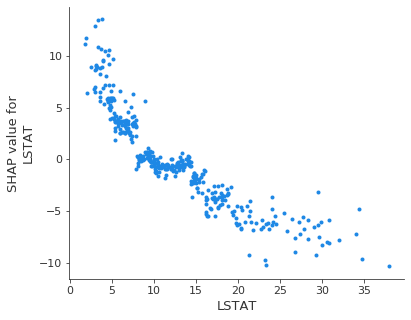

In [17]:
shap.dependence_plot("LSTAT", shap_values, Xtrain, interaction_index=None)

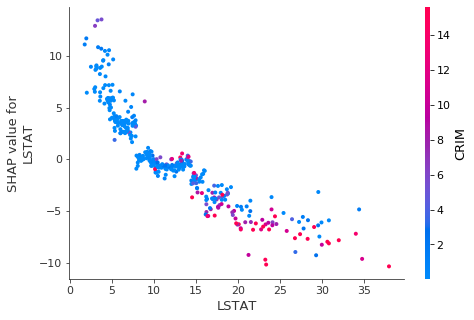

In [18]:
# Pick best interaction for me!
shap.dependence_plot("LSTAT", shap_values, Xtrain, interaction_index='auto')

## Local Interpretation

In [19]:
Xtest['ytrue'] = ytest
Xtest['ypred'] = test_preds
Xtest['residual'] = abs(Xtest['ytrue'] - Xtest['ypred'])
Xtest.sort_values(['residual'], ascending=False, inplace=True)

In [20]:
Xtest.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,ytrue,ypred,residual
409,14.43830,0.0,18.10,0.0,0.597,6.852,100.0,1.4655,24.0,666.0,20.2,179.36,19.78,27.5,12.748761,14.751239
181,0.06888,0.0,2.46,0.0,0.488,6.144,62.2,2.5979,3.0,193.0,17.8,396.90,9.45,36.2,23.010517,13.189483
371,9.23230,0.0,18.10,0.0,0.631,6.216,100.0,1.1691,24.0,666.0,20.2,366.15,9.53,50.0,39.559410,10.440590
408,7.40389,0.0,18.10,0.0,0.597,5.617,97.9,1.4547,24.0,666.0,20.2,314.64,26.40,17.2,8.853674,8.346326
411,14.05070,0.0,18.10,0.0,0.597,6.657,100.0,1.5275,24.0,666.0,20.2,35.05,21.22,17.2,8.960155,8.239845


In [21]:
Xtest.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,ytrue,ypred,residual
137,0.35233,0.0,21.89,0.0,0.624,6.454,98.4,1.8498,4.0,437.0,21.2,394.08,14.59,17.1,17.285618,0.185618
316,0.31827,0.0,9.90,0.0,0.544,5.914,83.2,3.9986,4.0,304.0,18.4,390.70,18.33,17.8,17.662704,0.137296
312,0.26169,0.0,9.90,0.0,0.544,6.023,90.4,2.8340,4.0,304.0,18.4,396.30,11.72,19.4,19.516697,0.116697
19,0.72580,0.0,8.14,0.0,0.538,5.727,69.5,3.7965,4.0,307.0,21.0,390.95,11.28,18.2,18.097162,0.102838
485,3.67367,0.0,18.10,0.0,0.583,6.312,51.9,3.9917,24.0,666.0,20.2,388.62,10.58,21.2,21.144400,0.055600


In [22]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(Xtest[features])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Force Plot

In [29]:
# Most correct
shap.force_plot(explainer.expected_value, shap_values[-1, :], Xtest.iloc[-1][features])

In [26]:
# Expected value = E(ytrain)
explainer.expected_value, ytrain.mean()

(22.907793, 22.907915567282323)

In [33]:
pd.DataFrame(shap_values[-1, :], index=features)

,0
CRIM,0.120979
ZN,-0.026501
INDUS,0.359214
CHAS,0.014913
NOX,-0.083711
RM,-1.669985
AGE,0.711082
DIS,0.188674
RAD,0.122198
TAX,-0.470654


In [34]:
np.sum(shap_values[-1])

-1.7634004

In [35]:
ytrain.mean()

22.907915567282323

In [36]:
ytrain.mean() + np.sum(shap_values[-1])

21.14451513183463

In [37]:
# Most wrong
shap.force_plot(explainer.expected_value, shap_values[0, :], Xtest.iloc[0][features])

### Cluster Plot

SHAP cluster sample by similarity of shapley value in each features.

In [39]:
n = 20
top_error = Xtest.iloc[:20, :]
top_error_shap = shap_values[:20, :]

In [43]:
top_error

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,ytrue,ypred,residual
409,14.43830,0.0,18.10,0.0,0.5970,6.852,100.0,1.4655,24.0,666.0,20.2,179.36,19.78,27.5,12.748761,14.751239
181,0.06888,0.0,2.46,0.0,0.4880,6.144,62.2,2.5979,3.0,193.0,17.8,396.90,9.45,36.2,23.010517,13.189483
371,9.23230,0.0,18.10,0.0,0.6310,6.216,100.0,1.1691,24.0,666.0,20.2,366.15,9.53,50.0,39.559410,10.440590
408,7.40389,0.0,18.10,0.0,0.5970,5.617,97.9,1.4547,24.0,666.0,20.2,314.64,26.40,17.2,8.853674,8.346326
411,14.05070,0.0,18.10,0.0,0.5970,6.657,100.0,1.5275,24.0,666.0,20.2,35.05,21.22,17.2,8.960155,8.239845
268,0.54050,20.0,3.97,0.0,0.5750,7.470,52.6,2.8720,5.0,264.0,13.0,390.30,3.16,43.5,50.806511,7.306511
412,18.81100,0.0,18.10,0.0,0.5970,4.628,100.0,1.5539,24.0,666.0,20.2,28.79,34.37,17.9,11.512369,6.387631
365,4.55587,0.0,18.10,0.0,0.7180,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12,27.5,21.328684,6.171316
489,0.18337,0.0,27.74,0.0,0.6090,5.414,98.3,1.7554,4.0,711.0,20.1,344.05,23.97,7.0,12.776893,5.776893
375,19.60910,0.0,18.10,0.0,0.6710,7.313,97.9,1.3163,24.0,666.0,20.2,396.90,13.44,15.0,20.654991,5.654991


In [42]:
shap.force_plot(explainer.expected_value, top_error_shap, top_error[features])


We can use any Clustering algorithm to cluster samples.

In [44]:
# N sample x M features
# Each features is shapley
shap_values.shape

(127, 13)